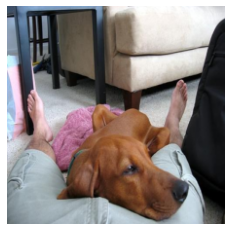

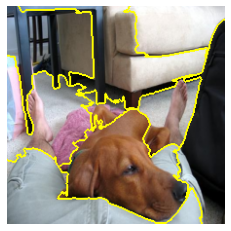

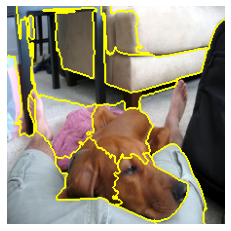

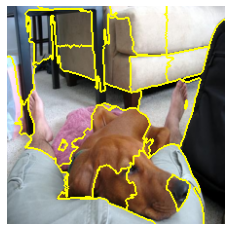

In [48]:
# import the necessary packages
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import torchvision
import torch
import random
import torch.nn as nn
import litdata
from skimage.filters import sobel
from skimage.color import rgb2gray


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), 
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image)

plt.imshow(image)
plt.axis("off")
plt.show()

gradient = sobel(rgb2gray(image))

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply SLIC and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of SLIC
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, filters

def initialize_seeds(img, num_superpixels):
    """Initialize seeds for waterpixel superpixels."""
    rows, cols = img.shape
    N = int(np.sqrt(num_superpixels))
    step = rows // N
    seeds = np.zeros((rows, cols), dtype=int)
    id = 1
    for i in range(step // 2, rows, step):
        for j in range(step // 2, cols, step):
            if i < rows and j < cols:
                seeds[i, j] = id
                id += 1
    return seeds

def compute_gradient(img):
    """Compute the gradient magnitude of the image."""
    gradient = filters.sobel(color.rgb2gray(img))
    return gradient

def region_growing(seeds, gradient):
    """Grow regions based on gradient and initial seeds."""
    rows, cols = gradient.shape
    labels = np.zeros_like(seeds)
    # List of seed points
    active_list = [(i, j) for i in range(rows) for j in range(cols) if seeds[i, j] > 0]
    while active_list:
        new_active_list = []
        for x, y in active_list:
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        if labels[nx, ny] == 0 and gradient[nx, ny] < 0.1:  # Threshold to stop growing
                            labels[nx, ny] = seeds[x, y]
                            new_active_list.append((nx, ny))
        active_list = new_active_list
    return labels

def plot_results(img, labels):
    """Plot the results of the segmentation."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(labels, cmap='nipy_spectral')
    ax[1].set_title('Waterpixel Segmentation')
    ax[1].axis('off')
    
    plt.show()

def main_waterpixels(img, num_superpixels):
    seeds = initialize_seeds(img, num_superpixels)
    gradient = compute_gradient(img)
    labels = region_growing(seeds, gradient)
    plot_results(img, labels)


main_waterpixels(image, 100)

ValueError: the input array must have size 3 along `channel_axis`, got (224, 224)

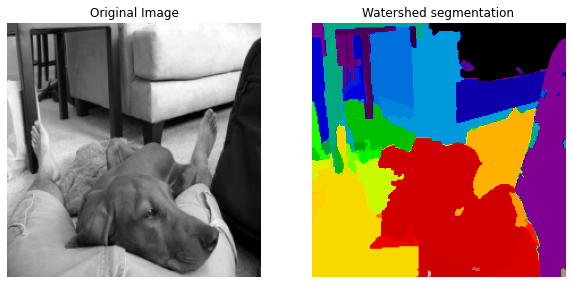

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel

def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel(image)

    # Generate markers
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    from scipy.ndimage import label, generate_binary_structure
    labeled, _ = label(markers)
    
    structure = generate_binary_structure(2, 2)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()


watershed_from_scratch(image)

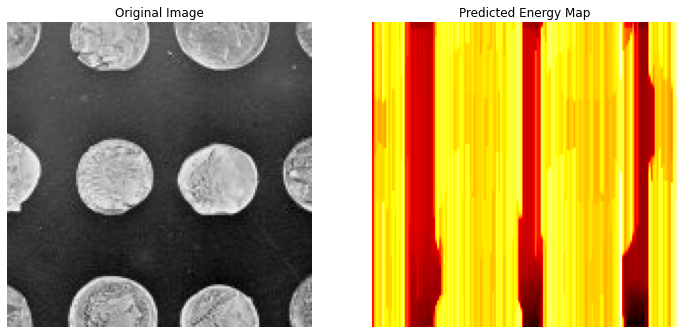

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

class EnergyMapPredictor(nn.Module):
    """ A simple CNN to predict an energy map from an image. """
    def __init__(self):
        super(EnergyMapPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def soft_watershed(energy_map, iterations=100, decay_factor=0.99):
    """ Perform a soft watershed algorithm. """
    h, w = energy_map.shape[-2:]
    grid_x, grid_y = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    grid_x = grid_x.float().to(energy_map.device)
    grid_y = grid_y.float().to(energy_map.device)
    
    # Initialize the water height as the negative energy map
    water_height = -energy_map.squeeze(1)

    for _ in range(iterations):
        # Compute local gradients
        grad_x = torch.roll(water_height, shifts=1, dims=0) - water_height
        grad_y = torch.roll(water_height, shifts=1, dims=1) - water_height

        # Flow water
        flow_x = F.relu(grad_x)
        flow_y = F.relu(grad_y)
        
        flow = flow_x + flow_y
        water_height += flow * decay_factor  # Update heights

    return water_height

def visualize(image, prediction):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(prediction.squeeze().detach().numpy(), cmap='hot')
    plt.title('Predicted Energy Map')
    plt.axis('off')
    plt.show()

# Load an example image
image = data.coins()[50:200, 50:200]  # Crop for simplicity
image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0  # CxHxW

# Model and prediction
model = EnergyMapPredictor()
predicted_energy_map = model(image)
watershed_output = soft_watershed(predicted_energy_map)

# Visualization
visualize(image, watershed_output)

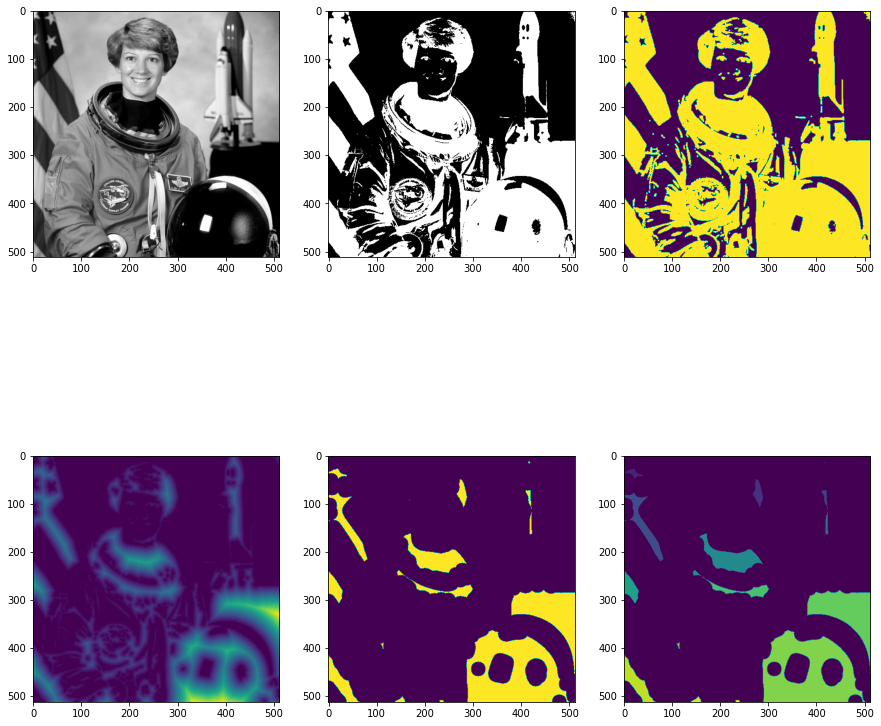

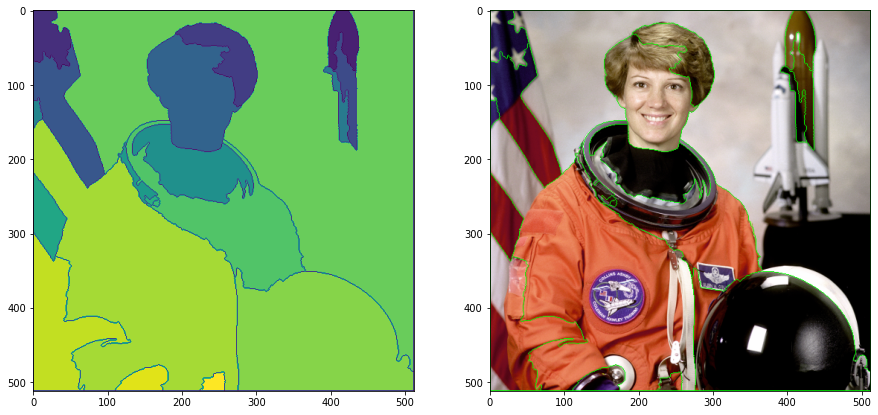

In [46]:
import cv2 as cv 
import matplotlib.pyplot as plt
import numpy as np
import os

def watershed():
    img = image
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(231)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(232)
    _, imageThreshold = cv.threshold(img,120,255,cv.THRESH_BINARY_INV)
    plt.imshow(imageThreshold, cmap='gray')
    
    plt.subplot(233)
    kernel = np.ones((3,3),np.uint8)
    imgDilate = cv.morphologyEx(imageThreshold, cv.MORPH_DILATE, kernel)
    plt.imshow(imgDilate)
    
    plt.subplot(234)
    dist_transform = cv.distanceTransform(imgDilate, cv.DIST_L2, 5)
    plt.imshow(dist_transform)
    
    plt.subplot(235)
    _, distThresh = cv.threshold(dist_transform, 15, 255, cv.THRESH_BINARY)
    plt.imshow(distThresh)
    
    plt.subplot(236)
    distThresh = np.uint8(distThresh)
    _, labels = cv.connectedComponents(distThresh)
    plt.imshow(labels)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    labels = np.int32(labels)
    labels = cv.watershed(imgRGB, labels)
    plt.imshow(labels)
    
    plt.subplot(122)
    imgRGB[labels == -1] = [0,255,0]
    plt.imshow(imgRGB)
    
    
    plt.show()
    
watershed()